# Notebook to compute the frontogenesis function of some property $q$ in two dimensions. 
Original description and code directly for the FGF by Hetland and Qu (in-prep). 

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
from timeit import default_timer as timer

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
paths = ['https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_his_2021_v2_agg']

def open_roms(path):
    ds1 = xroms.open_mfnetcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds, grid = open_roms(paths)

## Rob Hetland's description from Hetland and Qu (in prep): modified by Dylan Schlichting
### The 'Frontogenesis function' $F$ of a property $q$ may be written as (Hoskins, 1982)

<font size="3">
$ F = \frac{1}{2}\frac{D}{Dt} \left( \frac{\partial q}{\partial x_j} \right)^2 = - \frac{\partial q}{\partial x_j} \frac{\partial u_i}{\partial x_j} \frac{\partial q}{\partial x_i}$
</font>

Since we are concerned with surface fronts, we will use the two-dimensional form of $F$. This is written as 

<font size="3">
$ F = \left(\frac{\partial q}{\partial x} \right) \left(- \frac{\partial u}{\partial x} \frac{\partial q}{\partial x} - \frac{\partial v}{\partial x} \frac{\partial q}{\partial y} \right) + \left(\frac{\partial q}{\partial y} \right) \left(- \frac{\partial u}{\partial y} \frac{\partial q}{\partial x} - \frac{\partial v}{\partial y} \frac{\partial q}{\partial y} \right)$
</font>

The 'normalized frontogenesis funtion' $\hat{F}$ is used to account for the strength of the Coriolis parameter and the magnitude of the local property gradients.

<font size="3">
$ \hat{F} = \frac{1}{2 f |\nabla q|^2} \frac{D}{Dt} \left( \frac{\partial q}{\partial x_j} \right)^2 = \frac{\left(\frac{\partial q}{\partial x} \right) \left(- \frac{\partial u}{\partial x} \frac{\partial q}{\partial x} - \frac{\partial v}{\partial x} \frac{\partial q}{\partial y} \right) + \left(\frac{\partial q}{\partial y} \right) \left(- \frac{\partial u}{\partial y} \frac{\partial q}{\partial x} - \frac{\partial v}{\partial y} \frac{\partial q}{\partial y} \right)}{f \bigg[ \left(\frac{\partial q}{\partial x} \right)^2+ \left(\frac{\partial q}{\partial y} \right)^2 \bigg]}$
</font>

Physically, when $\hat{F}>0$, frontogenesis of $q$ is occuring. When $\hat{F}<0$, frontolysis of $q$ is occuring.

In [3]:
def norm_fgf(ds,grid, q):

    dqdx = xroms.to_rho(grid.derivative(q, 'X'),grid) # defined at rho-points
    dqdy = xroms.to_rho(grid.derivative(q, 'Y'),grid)

    us = ds.u.isel(s_rho = -1) # surface velocity field
    vs = ds.v.isel(s_rho = -1)

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'),grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'),grid)

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'FGF'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nFGF = Ddelq2 / (gradq2 * ds.f)
    nFGF.name = r'nFGF'
    return nFGF

In [4]:
# Run function and display output to check before loading
nfgf1 = norm_fgf(ds, grid, ds.salt.isel(s_rho = -1))
nfgf1

<xarray.DataArray 'nFGF' (ocean_time: 721, eta_rho: 191, xi_rho: 671)>
dask.array<truediv, shape=(721, 191, 671), dtype=float64, chunksize=(1, 191, 671), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 664 665 666 667 668 669 670
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * ocean_time  (ocean_time) datetime64[ns] 2021-06-11 ... 2021-07-11
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
Attributes:
    long_name:    salinity
    time:         ocean_time
    grid:         grid
    location:     face
    field:        salinity, scalar, series
    _ChunkSizes:  [  1  15  96 336]

In [5]:
# Time how long it takes to do the calculation for one snapshot in seconds
start = timer()
nfgf = nfgf1[96].load()
elapsed_time = timer() - start 
print(elapsed_time)

49.713113602949306


## Extremely slow! If we wanted to do the entire domain for a month, round up to 50 s/snapshot, which is for one hour of output.
(50 s/snapshot)*(24 snapshots/day)*(30 days/month)/(3600 s/hr) ~ 10 hours of real life computation time... for the parent model

###  Plot a snapshot for the entire domain. Expecting the fronts to be tough to see because the default DPI is used, so zoom in afterwards.

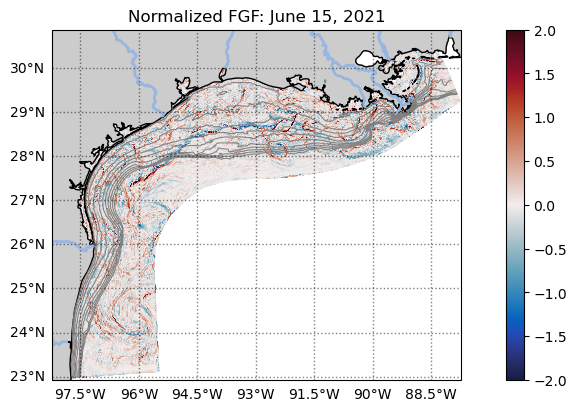

In [6]:
nrows = 1; ncols = 1
lat_rad = 1.0/np.cos(np.radians(ds.lat_rho.mean().values))

fig,ax = plt.subplots(nrows,ncols,figsize=(18/1.75,8/2),
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True)

m = ax.pcolormesh(ds.lon_rho,
                  ds.lat_rho,
                  nfgf, 
                  cmap = cmo.balance, vmin = -2, vmax = 2,
                  transform = ccrs.PlateCarree())

plt.colorbar(m).set_label(r'')

hlevs = [10, 20, 30, 40, 50, 60, 70, 80,90,100] # isobath contour depths
ax.contour(ds.lon_rho,
           ds.lat_rho,
           ds.h, hlevs, colors='grey', 
           transform=ccrs.PlateCarree(), linewidths=0.75)
# ax.set_extent([-95, -88, 27.75, 30.5], crs=ccrs.PlateCarree()) # query axes limits in lon/lat
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.set_aspect(lat_rad) # set aspect ratio
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Normalized FGF: June 15, 2021')

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True) # grid lines 
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
    
fig.canvas.draw()

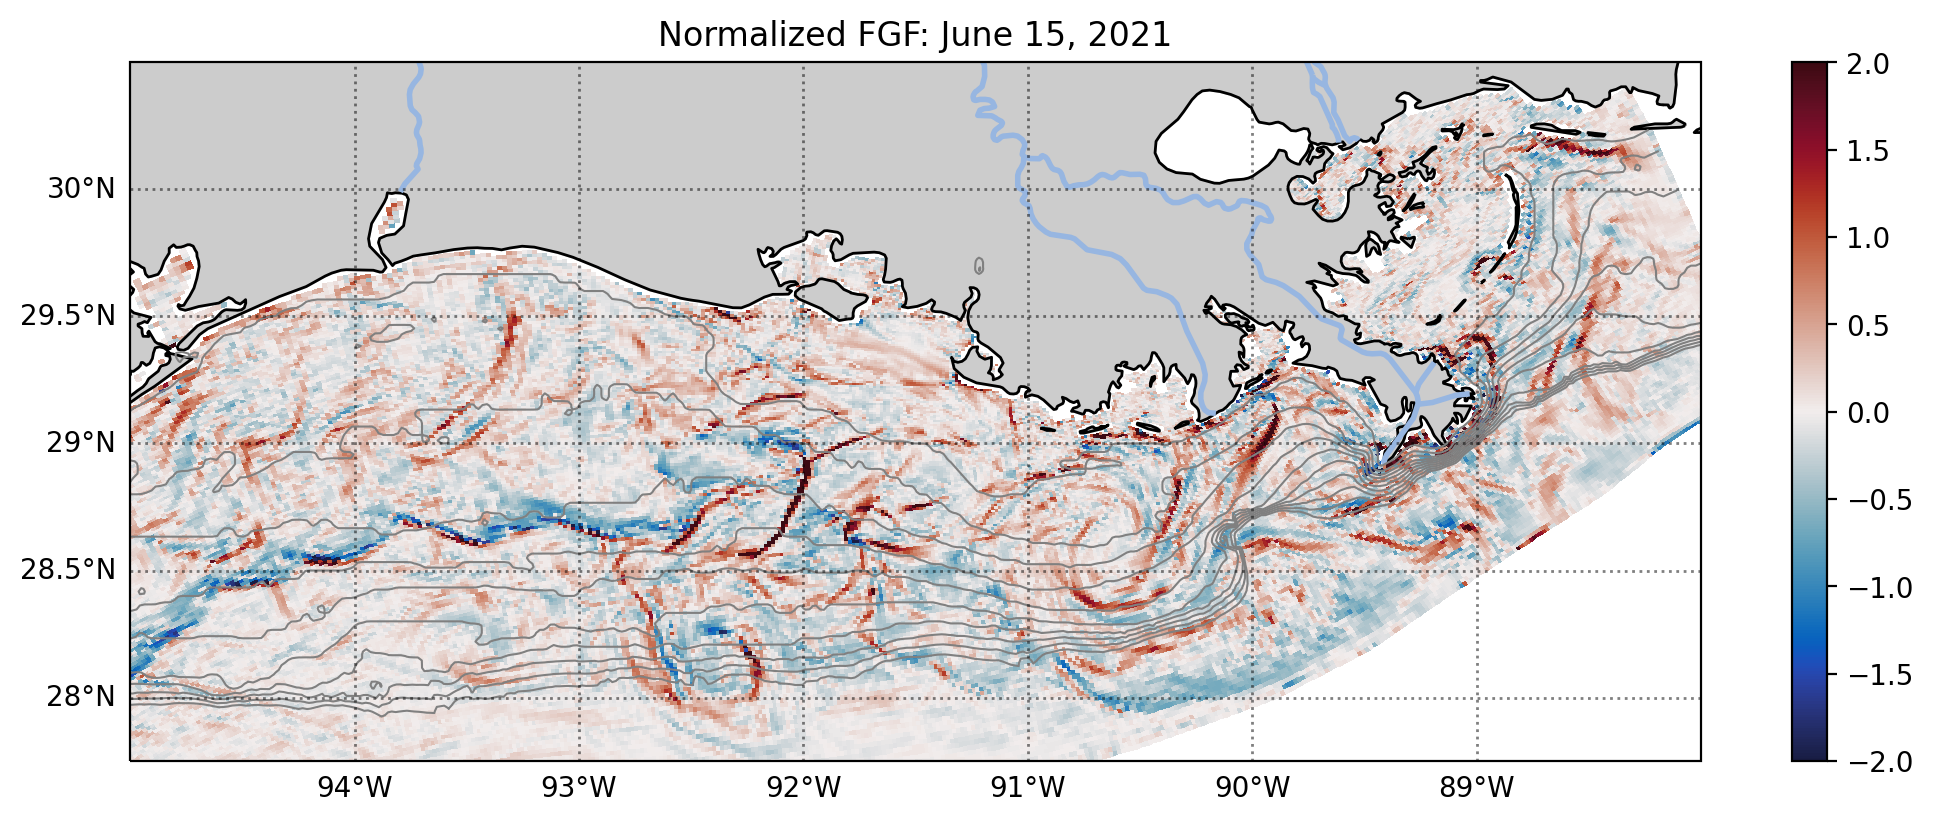

In [7]:
fig,ax = plt.subplots(nrows,ncols,figsize=(18/1.75,8/2),
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True, dpi = 200)

m = ax.pcolormesh(ds.lon_rho,
                  ds.lat_rho,
                  nfgf, 
                  cmap = cmo.balance, vmin = -2, vmax = 2,
                  transform = ccrs.PlateCarree())

plt.colorbar(m).set_label(r'')

hlevs = [10, 20, 30, 40, 50, 60, 70, 80,90,100] # isobath contour depths
ax.contour(ds.lon_rho,
           ds.lat_rho,
           ds.h, hlevs, colors='grey', 
           transform=ccrs.PlateCarree(), linewidths=0.75)
ax.set_extent([-95, -88, 27.75, 30.5], crs=ccrs.PlateCarree()) # query axes limits in lon/lat
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.set_aspect(lat_rad) # set aspect ratio
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Normalized FGF: June 15, 2021')

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True) # grid lines 
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
    
fig.canvas.draw()

## Conclusions: Sharp fronts are easy to find and the calculation of $\hat{F}$, even for the surface only, is very slow. 
This is due to the large number of flow/property gradients and subsequent interpolation required.